# Collaborative Filtering Based Recommender Systems using Low Rank Embeddings

A general Keras implementation of the CF based Recommender System on user and movie embedding using Neural Network.
Let's import some required libraries.

In [20]:
# Standard Lib's
import numpy as np
import pandas as pd

# Keras Lib's
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, Dropout, BatchNormalization
from tensorflow.keras.layers import dot
from tensorflow.keras.optimizers import Adam

# Image Processing and Visualization Lib's
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

# Required Lib's
import warnings

# Parameters
warnings.filterwarnings('ignore')
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

In [3]:
# Read the Ratings Data
data = pd.read_csv('data/movie-lens-100k/ratings.csv')
data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
# Explore Dataset
print(data.columns)
print(f"No. of unique users in dataset: {data['userId'].unique().__len__()}")
print(f"No. unique movies in dataset: {data['movieId'].unique().__len__()}")

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
No. of unique users in dataset: 671
No. unique movies in dataset: 9066


In [5]:
# Check for Null Values
data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
# Change ID columns to Category and Encode them
# Change ID columns to Categories
data['userId'] = data['userId'].astype('category')
data['movieId'] = data['movieId'].astype('category')

# Select category columns
cat_cols = data.select_dtypes(['category']).columns

# Encode Category Column Values
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes.values)

# Check the Data Now
data[cat_cols].head()

,userId,movieId
0,0,30
1,0,833
2,0,859
3,0,906
4,0,931


In [8]:
# Training and Validation Sets
# Get Unique Users and Movies
users = data.userId.unique()
movies = data.movieId.unique()

# Create Dictionary of userId/movieId to Id
uId_Id = {uid: i for i, uid in enumerate(users)}
mId_Id = {mid: i for i, mid in enumerate(movies)}

print(uId_Id, mId_Id)

data['userId'] = data['userId'].apply(lambda x: uId_Id[x])
data['movieId'] = data['movieId'].apply(lambda x: mId_Id[x])

# Train and Validation Split Data
split = np.random.rand(len(data)) < 0.9
train = data[split]
valid = data[~split]

print(train.shape, valid.shape)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [9]:
# Low Rank Embedding
n_movies = len(data['movieId'].unique())
n_users = len(data['userId'].unique())
n_features = 64  # No. of dimensions in Embedding Vector

# User Input
user_input = Input(shape=(1, ), dtype='int64')

# Embedding Layer
user_embedding = Embedding(input_dim=n_users, output_dim=n_features)(user_input)

# Flatten the Embedded Vector
user_vec = Flatten()(user_embedding)

# Check Shape and Output
print(user_vec.shape, user_vec[0])




(?, ?) Tensor("strided_slice:0", shape=(?,), dtype=float32)


In [10]:
# Doing the Same for Movies
# Movie Input
movie_input = Input(shape=(1, ), dtype='int64')

# Embedding Layer
movie_embedding = Embedding(input_dim=n_movies, output_dim=n_features)(movie_input)

# Flatten the Embedding Layer
movie_vec = Flatten()(movie_embedding)

# Check Shape and Output
print(movie_vec.shape, movie_vec[0])

(?, ?) Tensor("strided_slice_1:0", shape=(?,), dtype=float32)


In [11]:
# Find Similarity between the two vectors
sim = dot([user_vec, movie_vec], axes=1)

# Keras Model
model = Model([user_input, movie_input], sim)

# Check Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        42944       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 64)        580224      input_2[0][0]                    
____________________________________________________________________________________________

In [12]:
# Compile Model
model.compile(optimizer=Adam(lr=1e-4), loss='mse')

# Set Hyper-parameters for the Model
batch_size = 128
epochs = 75

# Fit the Model on Training and Validate on validation dataset
history = model.fit([train.userId, train.movieId], 
                    train.rating, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid.userId, valid.movieId], valid.rating),
                    verbose=2)




Train on 90043 samples, validate on 9961 samples
Epoch 1/75
 - 7s - loss: 13.6914 - val_loss: 13.5442
Epoch 2/75
 - 6s - loss: 13.6792 - val_loss: 13.5378
Epoch 3/75
 - 6s - loss: 13.6499 - val_loss: 13.5003
Epoch 4/75
 - 6s - loss: 13.5483 - val_loss: 13.3389
Epoch 5/75
 - 7s - loss: 13.2288 - val_loss: 12.8710
Epoch 6/75
 - 6s - loss: 12.5169 - val_loss: 11.9724
Epoch 7/75
 - 6s - loss: 11.3758 - val_loss: 10.6964
Epoch 8/75
 - 6s - loss: 9.9271 - val_loss: 9.2110
Epoch 9/75
 - 6s - loss: 8.3636 - val_loss: 7.7103
Epoch 10/75
 - 7s - loss: 6.8762 - val_loss: 6.3642
Epoch 11/75
 - 7s - loss: 5.6107 - val_loss: 5.2803
Epoch 12/75
 - 7s - loss: 4.6314 - val_loss: 4.4742
Epoch 13/75
 - 7s - loss: 3.9082 - val_loss: 3.8823
Epoch 14/75
 - 6s - loss: 3.3688 - val_loss: 3.4351
Epoch 15/75
 - 7s - loss: 2.9495 - val_loss: 3.0821
Epoch 16/75
 - 6s - loss: 2.6120 - val_loss: 2.7956
Epoch 17/75
 - 6s - loss: 2.3348 - val_loss: 2.5599
Epoch 18/75
 - 6s - loss: 2.1041 - val_loss: 2.3645
Epoch 1

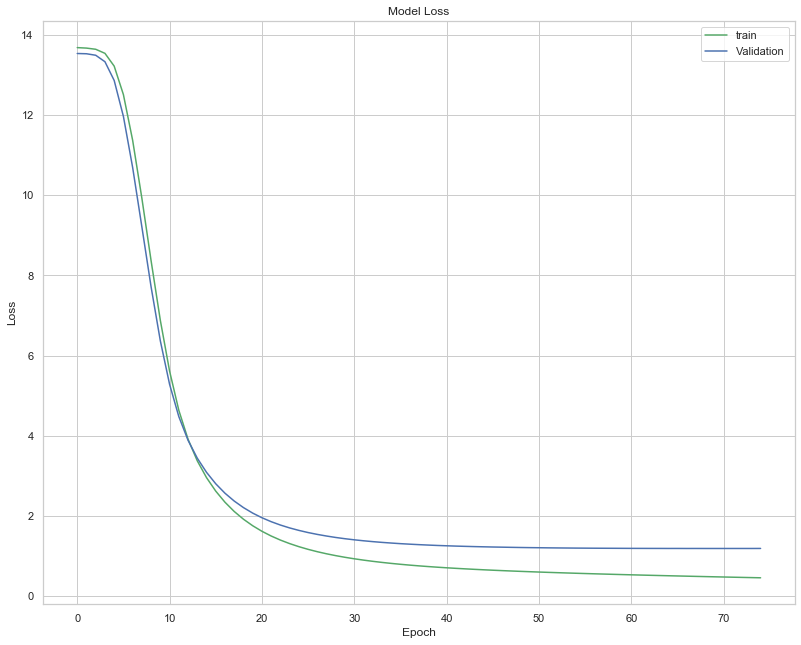

In [13]:
# Evaluate Model Performance
plt.figure(figsize=(12, 10))
plt.plot(history.history['loss'], c='g')
plt.plot(history.history['val_loss'], c= 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='best')
plt.grid(True)
plt.show()

In [14]:
# Trying a bigger NN Architecture, BatchNorm, Dropout Reg...
# Let's Rebuild the Vector Representation of Users and Movies
# User Input
user_input = Input(shape=(1, ), dtype='int64')

# Embedding Layer
user_embedding = Embedding(input_dim=n_users, output_dim=n_features)(user_input)

# Flatten the Embedded Vector
user_vec = Flatten()(user_embedding)

# Add Dropout Layer
user_vec = Dropout(0.4)(user_vec)

# Movie Input
movie_input = Input(shape=(1, ), dtype='int64')

# Embedding Layer
movie_embedding = Embedding(input_dim=n_movies, output_dim=n_features)(movie_input)

# Flatten the Embedding Layer
movie_vec = Flatten()(movie_embedding)

# Dropout Layer
movie_vec = Dropout(0.4)(movie_vec)

# Find Similarity between the two vectors
sim = dot([user_vec, movie_vec], axes=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# Let's Build a Model Architecture
model_inp = Dense(128, activation='relu')(sim)
model_inp = Dropout(0.4)(model_inp)
model_inp = BatchNormalization()(model_inp)
model_inp = Dense(1, activation='relu')(model_inp)

# Define Model
model = Model(inputs=[user_input, movie_input], outputs=model_inp)

# Check the built Model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 64)        42944       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 64)        580224      input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
# Compile the Model
model.compile(optimizer=Adam(lr=1e-4), loss='mse')

In [17]:
# Define Model Parameters
batch_size = 128
epochs = 25

In [18]:
# Fit the Model
history = model.fit([train.userId, train.movieId], 
                    train.rating, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid.userId, valid.movieId], valid.rating), 
                    verbose=2)

Train on 90043 samples, validate on 9961 samples
Epoch 1/25
 - 8s - loss: 8.4635 - val_loss: 3.0484
Epoch 2/25
 - 7s - loss: 1.6400 - val_loss: 1.1374
Epoch 3/25
 - 8s - loss: 1.1181 - val_loss: 1.1377
Epoch 4/25
 - 7s - loss: 1.1135 - val_loss: 1.1379
Epoch 5/25
 - 8s - loss: 1.1051 - val_loss: 1.1381
Epoch 6/25
 - 8s - loss: 1.0830 - val_loss: 1.1333
Epoch 7/25
 - 8s - loss: 1.0514 - val_loss: 1.1330
Epoch 8/25
 - 7s - loss: 1.0191 - val_loss: 1.1425
Epoch 9/25
 - 8s - loss: 0.9887 - val_loss: 1.1297
Epoch 10/25
 - 8s - loss: 0.9588 - val_loss: 1.1366
Epoch 11/25
 - 8s - loss: 0.9338 - val_loss: 1.1308
Epoch 12/25
 - 7s - loss: 0.9062 - val_loss: 1.1312
Epoch 13/25
 - 8s - loss: 0.8881 - val_loss: 1.1222
Epoch 14/25
 - 8s - loss: 0.8642 - val_loss: 1.1257
Epoch 15/25
 - 8s - loss: 0.8524 - val_loss: 1.1289
Epoch 16/25
 - 8s - loss: 0.8330 - val_loss: 1.1156
Epoch 17/25
 - 7s - loss: 0.8145 - val_loss: 1.1236
Epoch 18/25
 - 8s - loss: 0.8064 - val_loss: 1.1279
Epoch 19/25
 - 7s - loss

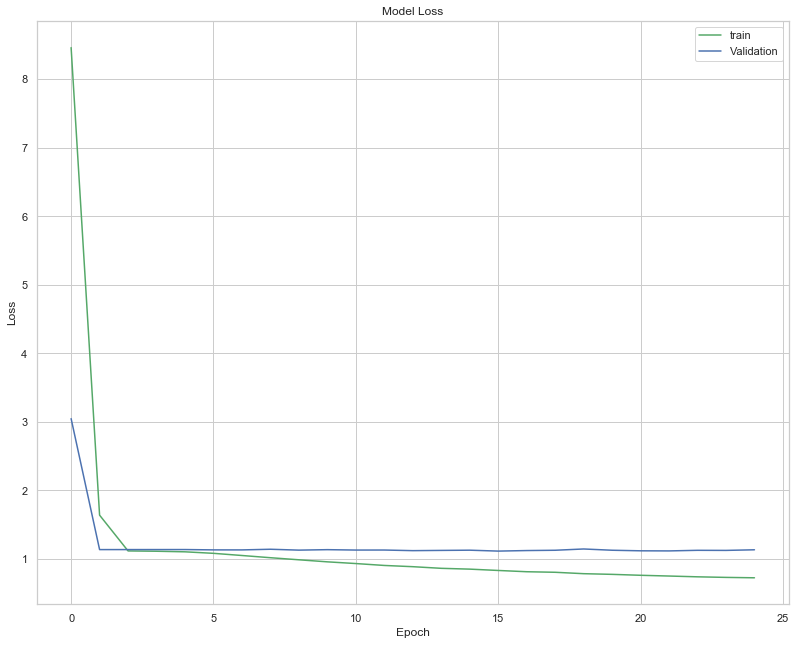

In [19]:
# Plot the Results
# Evaluate Model Performance
plt.figure(figsize=(12, 10))
plt.plot(history.history['loss'], c='g')
plt.plot(history.history['val_loss'], c= 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='best')
plt.grid(True)
plt.show()
